In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import pickle

In [3]:
def initializeWeights(n_in,n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
                            
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1);
    W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon;
    return W

In [4]:
# Replace this with your sigmoid implementation
def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    sig = 1.0 / (1.0 + np.exp(-1.0 * z))
    return sig

In [5]:
def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log
    %   likelihood error function with regularization) given the parameters
    %   of Neural Networks, thetraining data, their corresponding training
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.

    % Output:
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden
    %     layer to unit i in output layer."""
    # d = 713

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))  # m * (d+1)
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1))) # 10 * (m+1)
    obj_val = 0

    # Your code here
    n = training_data.shape[0]
    bias_term = np.ones((training_data.shape[0], 1))
    training_data = np.append(training_data, bias_term, 1)

    O1 = np.dot(training_data, np.transpose(w1)) # 50000 * m
    z = sigmoid(O1)  # Output of hidden layer
    z_j = z  # 50000 * m - without bias term
    bias_term = np.ones((z.shape[0], 1)) # adding a bias term to the hidden layer
    z = np.append(z, bias_term, 1)  # 50000 * m+1
    O2 = np.dot(z, np.transpose(w2))  # 50000 * 10
    Op = sigmoid(O2)  # 50000 * 10

    # 1-of-K coding scheme of input data
    y = np.zeros([training_label.shape[0], n_class])
    y[np.arange(training_label.shape[0]), training_label.astype(int)] = 1.0

    J_error =  np.sum(np.multiply(y, np.log(Op)) + np.multiply((1 - y), np.log((1-Op)))) * (-1 / n_input) # change n_input
    reg_term = (lambdaval / (2 * n_input)) * (np.sum(np.square(w1)) + np.sum(np.square(w2))) # equation 15
    # J_Regularization = J_error + reg_term
    obj_val = J_error + reg_term

    # Backpropagation
    delta_l = Op - y # 50000 * 10
    dJ_dw2 = np.dot(np.transpose(delta_l), z)  # 10 * m+1
    dJRegularization_dw2 = (dJ_dw2 + lambdaval * w2) / n  # equation 16
    grad_w2 = dJRegularization_dw2

    # considering the weights and z without bias
    # term1 = np.dot(delta_l, w2[:, :-1]) * (z_j * (1 - z_j))  # 50000 * m
    term1 = ((1 - z_j) * z_j) * (np.dot(delta_l, w2[:, :-1]))  # 50000 * m
    dJ_dw1 = np.dot(np.transpose(term1), training_data)
    dJRegularization_dw1 = (dJ_dw1 + lambdaval * w1) / n # m*714 (considering selected features from preprocess)  --- # equation 17
    grad_w1 = dJRegularization_dw1

    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)

    # obj_grad = np.array([])

    return (obj_val, obj_grad)


In [6]:
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature
    %       vector of a particular image

    % Output:
    % label: a column vector of predicted labels"""
    # Your code here
    bias_column = np.ones((data.shape[0], 1))
    data = np.append(data, bias_column, 1)
    Oh = np.dot(data, np.transpose(w1))
    z1 = sigmoid(Oh)
    bias_column = np.ones((z1.shape[0], 1))
    z1 = np.append(z1, bias_column, 1)  # Add bias term
    Op = np.dot(z1, np.transpose(w2))
    Out_Class = sigmoid(Op)
    labels = np.argmax(Out_Class, axis=1)
    return labels

In [7]:
# Do not change this
def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = labels[0]
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

## Hyperparameter Tuning

Step 1: Increasing the lambda value and keeping the number of hidden nodes 20 **constant** to check the accuracy variation according to lambda

In [21]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

In [22]:
import numpy as np
from scipy.optimize import minimize
import time



# Neural network parameters
n_input = train_data.shape[1]  # Number of nodes in input layer
n_hidden = 256                 # Number of nodes in hidden layer
n_class = 2                    # Number of nodes in output layer

# Initialize weights
initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

# Optimization options
opts = {'maxiter': 50}         # Preferred value for maximum iterations

# List to store validation accuracies for each lambda
validation_accuracies = []

# Loop through lambdaval from 0 to 60 in steps of 10
for lambdaval in range(0, 61, 10):
    print(f'\nTraining Neural Network with lambda = {lambdaval}')
    
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    
    # Train the network
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    runtime = time.time() - start_time
    
    params = nn_params.get('x')
    
    # Reshape parameters into weight matrices
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # Calculate validation accuracy
    predicted_label = nnPredict(w1, w2, validation_data)
    validation_accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
    
    # Store accuracy in the list
    validation_accuracies.append((lambdaval, validation_accuracy))
    print(f'Validation set Accuracy for lambda = {lambdaval}: {validation_accuracy:.2f}%')
    print(f'Runtime: {runtime:.2f} seconds')

# Print all validation accuracies for reference
print("\nValidation Accuracies for Different Lambda Values:")
for lambdaval, accuracy in validation_accuracies:
    print(f'Lambda = {lambdaval}: Validation Accuracy = {accuracy:.2f}%')



Training Neural Network with lambda = 0
Validation set Accuracy for lambda = 0: 82.93%
Runtime: 503.86 seconds

Training Neural Network with lambda = 10
Validation set Accuracy for lambda = 10: 82.59%
Runtime: 739.32 seconds

Training Neural Network with lambda = 20
Validation set Accuracy for lambda = 20: 83.94%
Runtime: 461.27 seconds

Training Neural Network with lambda = 30
Validation set Accuracy for lambda = 30: 81.05%
Runtime: 505.51 seconds

Training Neural Network with lambda = 40
Validation set Accuracy for lambda = 40: 81.16%
Runtime: 463.71 seconds

Training Neural Network with lambda = 50
Validation set Accuracy for lambda = 50: 82.96%
Runtime: 473.01 seconds

Training Neural Network with lambda = 60
Validation set Accuracy for lambda = 60: 81.35%
Runtime: 492.39 seconds

Validation Accuracies for Different Lambda Values:
Lambda = 0: Validation Accuracy = 82.93%
Lambda = 10: Validation Accuracy = 82.59%
Lambda = 20: Validation Accuracy = 83.94%
Lambda = 30: Validation Acc

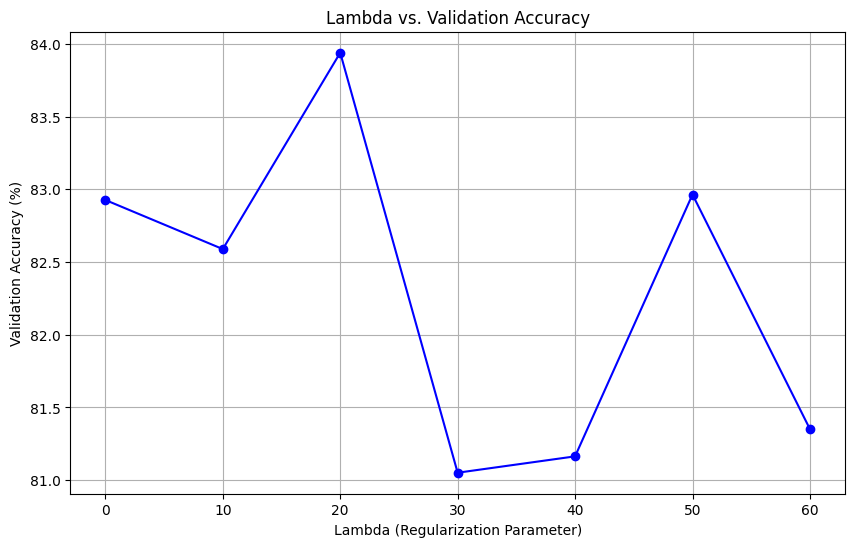

In [27]:
lambda_vals = [result[0] for result in validation_accuracies]
accuracies = [result[1] for result in validation_accuracies]

# Plot Lambda vs. Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.title("Lambda vs. Validation Accuracy")
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.xticks(lambda_vals)
plt.savefig("FaceNN_1", bbox_inches="tight")
plt.show()


Choosing Lambda as 20

In [26]:
# Define optimal lambda value
lambdaval = 20

# List of hidden layer sizes to test
hidden_layer_sizes = [64, 128, 256, 512]

# Store validation accuracies for each hidden layer size
validation_hidden_accuracies = []

for n_hidden in hidden_layer_sizes:
    print(f"Training with {n_hidden} hidden nodes")

    # Initialize weights for current hidden layer size
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Define arguments and optimization settings
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    opts = {'maxiter': 50}

    start_time = time.time()
    
    # Train Neural Network
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    
    # Measure end time and calculate runtime
    runtime = time.time() - start_time
    params = nn_params.get('x')

    # Reshape weights
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Calculate validation accuracy
    predicted_label = nnPredict(w1, w2, validation_data)
    validation_accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
    validation_hidden_accuracies.append((n_hidden, validation_accuracy, runtime))

    print(f"Validation Accuracy for {n_hidden} hidden nodes: {validation_accuracy}%")
    print(f"Runtime for {n_hidden} hidden nodes: {runtime} seconds")



Training with 64 hidden nodes
Validation Accuracy for 64 hidden nodes: 49.9812382739212%
Runtime for 64 hidden nodes: 14.043046474456787 seconds
Training with 128 hidden nodes
Validation Accuracy for 128 hidden nodes: 82.36397748592871%
Runtime for 128 hidden nodes: 320.4305193424225 seconds
Training with 256 hidden nodes


C:\Users\Amulya Reddy Datla\AppData\Local\Temp\ipykernel_27384\1657165631.py:63: RuntimeWarning: divide by zero encountered in log
  J_error =  np.sum(np.multiply(y, np.log(Op)) + np.multiply((1 - y), np.log((1-Op)))) * (-1 / n_input) # change n_input
C:\Users\Amulya Reddy Datla\AppData\Local\Temp\ipykernel_27384\1657165631.py:63: RuntimeWarning: invalid value encountered in multiply
  J_error =  np.sum(np.multiply(y, np.log(Op)) + np.multiply((1 - y), np.log((1-Op)))) * (-1 / n_input) # change n_input


Validation Accuracy for 256 hidden nodes: 82.96435272045028%
Runtime for 256 hidden nodes: 442.8996787071228 seconds
Training with 512 hidden nodes
Validation Accuracy for 512 hidden nodes: 80.86303939962477%
Runtime for 512 hidden nodes: 925.0703740119934 seconds


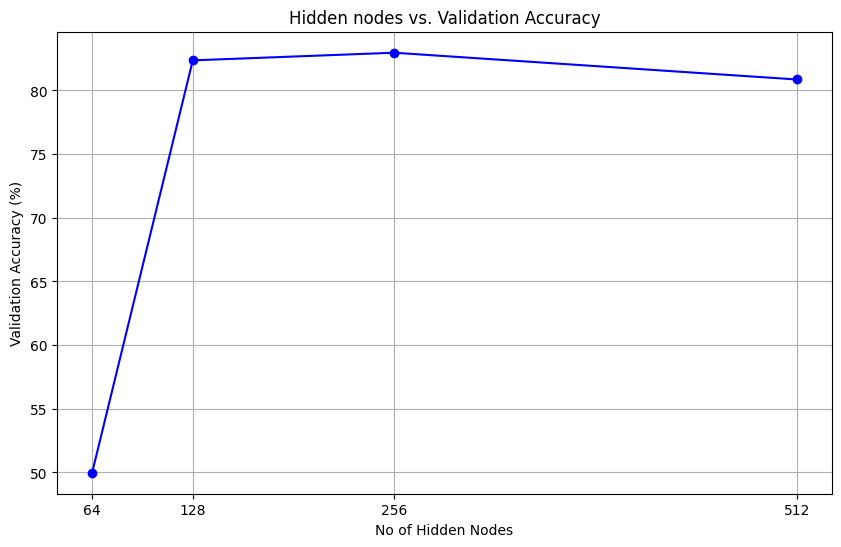

In [29]:
hidden_nodes = [result[0] for result in validation_hidden_accuracies]
hidden_accuracies = [result[1] for result in validation_hidden_accuracies]

# Plot Lambda vs. Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(hidden_nodes, hidden_accuracies, marker='o', linestyle='-', color='b', markersize=6)
plt.title("Hidden nodes vs. Validation Accuracy")
plt.xlabel("No of Hidden Nodes")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.xticks(hidden_nodes)
plt.savefig("FaceNN_2", bbox_inches="tight")
plt.show()


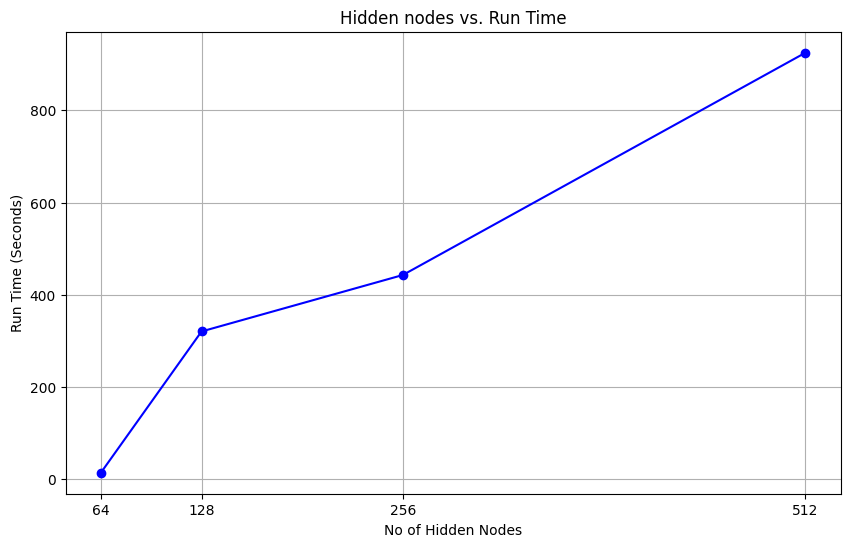

In [30]:
hidden_nodes = [result[0] for result in validation_hidden_accuracies]
hidden_runtime = [result[2] for result in validation_hidden_accuracies]

# Plot Lambda vs. Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(hidden_nodes, hidden_runtime, marker='o', linestyle='-', color='b', markersize=6)
plt.title("Hidden nodes vs. Run Time")
plt.xlabel("No of Hidden Nodes")
plt.ylabel("Run Time (Seconds)")
plt.grid(True)
plt.xticks(hidden_nodes)
plt.savefig("FaceNN_3", bbox_inches="tight")
plt.show()


Optimal Hidden nodes is 256

Running Train, Test and Validation data on the optimal lambda and hidden nodes values

In [32]:
"""**************Neural Network Script Starts here********************************"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()
#  Train Neural Network
# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]
# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 256
# set the number of nodes in output unit
n_class = 2

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden);
initial_w2 = initializeWeights(n_hidden, n_class);
# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()),0)
# set the regularization hyper-parameter
lambdaval = 20;
args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

#Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example
opts = {'maxiter' :50}    # Preferred value.

start_time = time.time()
nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args,method='CG', options=opts)
runtime = time.time() - start_time
params = nn_params.get('x')
#Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = params[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

#Test the computed parameters
predicted_label = nnPredict(w1,w2,train_data)
#find the accuracy on Training Dataset
print('\n Training set Accuracy:' + str(100*np.mean((predicted_label == train_label).astype(float))) + '%')
predicted_label = nnPredict(w1,w2,validation_data)
#find the accuracy on Validation Dataset
print('\n Validation set Accuracy:' + str(100*np.mean((predicted_label == validation_label).astype(float))) + '%')
predicted_label = nnPredict(w1,w2,test_data)
#find the accuracy on Validation Dataset
print('\n Test set Accuracy:' +  str(100*np.mean((predicted_label == test_label).astype(float))) + '%')

print(f'runtime: {runtime:.2f}s')



 Training set Accuracy:84.54976303317535%

 Validation set Accuracy:83.30206378986867%

 Test set Accuracy:83.76230128690386%
runtime: 489.63s


In [33]:
from sklearn.metrics import confusion_matrix

# Predict labels on the test dataset
predicted_test_label = nnPredict(w1, w2, test_data)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(test_label, predicted_test_label)
print("\nConfusion Matrix on Test Set:")
print(conf_matrix)



Confusion Matrix on Test Set:
[[1148  173]
 [ 256 1065]]


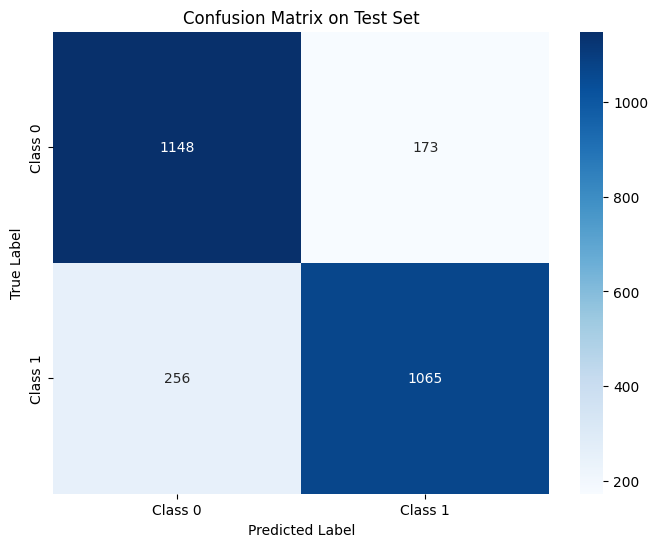

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig("FaceNN_CM", bbox_inches="tight")
plt.show()


In [37]:
for hidden_nodes, accuracy,runtime in validation_hidden_accuracies:
    print(f'Number of Hidden Nodes = {hidden_nodes}: Validation Accuracy = {accuracy:.2f}%  Run Time = {runtime:.2f}s')

Number of Hidden Nodes = 64: Validation Accuracy = 49.98%  Run Time = 14.04s
Number of Hidden Nodes = 128: Validation Accuracy = 82.36%  Run Time = 320.43s
Number of Hidden Nodes = 256: Validation Accuracy = 82.96%  Run Time = 442.90s
Number of Hidden Nodes = 512: Validation Accuracy = 80.86%  Run Time = 925.07s
